# Semantic Retrieval Model Pipeline

Notebook ini membangun model semantic retrieval berbasis FAISS dan SentenceTransformer dari dua dataset MBPP (real & clone).

**Alur utama:**
1. **Data Loading:** Gabungkan dua dataset JSON ke DataFrame.
2. **Embedding:** Buat embedding prompt dengan model multilingual.
3. **Indexing:** Normalisasi embedding dan buat FAISS IndexFlatIP untuk similarity search.
4. **Model Class:** Bungkus DataFrame, index, dan model ke dalam class `SemanticRetrievalModel`.
5. **Simpan Model:** Simpan retrieval model ke file `semantic_retrieval_model.pkl`.
6. **Evaluasi:** Pipeline evaluasi (precision, recall, f1, accuracy) dan hyperparameter tuning.
7. **Contoh Penggunaan:** Cara menggunakan model hasil PKL.

---

## Penjelasan Komponen Penting
- **FAISS IndexFlatIP:**
  - Index similarity berbasis inner product (dot product) yang efisien untuk pencarian embedding.
- **Normalisasi Embedding:**
  - Membuat vektor embedding menjadi unit norm agar inner product setara dengan cosine similarity.
- **SentenceTransformer:**
  - Model pre-trained untuk menghasilkan embedding kalimat multibahasa.
- **joblib:**
  - Untuk serialisasi (save/load) model Python ke file PKL.
- **search(query, top_k):**
  - Fungsi utama untuk mencari top-k prompt paling mirip secara semantik.
- **Pipeline Evaluasi:**
  - Mengukur performa retrieval dengan metrik klasifikasi (f1, precision, recall, accuracy).
- **Hyperparameter tuning:**
  - Mencari nilai top_k terbaik untuk retrieval.


In [1]:
# Install required packages
%pip install sentence-transformers faiss-cpu joblib sentencepiece transformers langdetect

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
# 1. Load and merge datasets with deduplication and normalization
import pandas as pd
import json
import re
from langdetect import detect, LangDetectException

with open('mbpp_real.json', 'r', encoding='utf-8') as f:
    real_data = json.load(f)
with open('mbpp_clone.json', 'r', encoding='utf-8') as f:
    clone_data = json.load(f)

def to_dataframe(data):
    if isinstance(data, list):
        return pd.DataFrame(data)
    elif isinstance(data, dict):
        return pd.DataFrame(list(data.values()))
    raise ValueError('Unknown data format')

def normalize_text(text):
    text = text.lower().strip()
    text = re.sub(r'\s+', ' ', text)
    return text

df_real = to_dataframe(real_data)[['prompt', 'code']]
df_clone = to_dataframe(clone_data)[['prompt', 'code']]
df = pd.concat([df_real, df_clone], ignore_index=True)
df['prompt'] = df['prompt'].apply(normalize_text)
df = df.drop_duplicates(subset='prompt').reset_index(drop=True)
print(f'Loaded {len(df)} unique prompts after deduplication.')

Loaded 583 unique prompts after deduplication.


In [4]:
# 1. Load and merge datasets with deduplication and normalization
import pandas as pd
import json
import re
from langdetect import detect, LangDetectException

with open('mbpp_real.json', 'r', encoding='utf-8') as f:
    real_data = json.load(f)
with open('mbpp_clone.json', 'r', encoding='utf-8') as f:
    clone_data = json.load(f)

def to_dataframe(data):
    if isinstance(data, list):
        return pd.DataFrame(data)
    elif isinstance(data, dict):
        return pd.DataFrame(list(data.values()))
    raise ValueError('Unknown data format')

def normalize_text(text):
    text = text.lower().strip()
    text = re.sub(r'\s+', ' ', text)
    return text

df_real = to_dataframe(real_data)[['prompt', 'code']]
df_clone = to_dataframe(clone_data)[['prompt', 'code']]
df = pd.concat([df_real, df_clone], ignore_index=True)
df['prompt'] = df['prompt'].apply(normalize_text)
df = df.drop_duplicates(subset='prompt').reset_index(drop=True)
print(f'Loaded {len(df)} unique prompts after deduplication.')

Loaded 583 unique prompts after deduplication.


In [5]:
# Load DataFrame & embeddings langsung dari JSON (tanpa generate ulang)
import pandas as pd
import numpy as np
import json

with open('mbpp_all_with_embedding.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
df = pd.DataFrame(data)
# Pastikan kolom embedding sudah ada dan bentuknya list of list
embeddings = np.array(df['embedding'].tolist())
print(f"Loaded {len(df)} rows, embedding shape: {embeddings.shape}")

Loaded 632 rows, embedding shape: (632, 2304)


In [6]:
df.head()

,prompt,code,embedding
0,Write a function to find the shared elements f...,"def similar_elements(test_tup1, test_tup2):\n ...","[-0.08133774250745773, -0.04932917654514313, -..."
1,Write a python function to identify non-prime ...,import math\ndef is_not_prime(n):\n result ...,"[0.006655762437731028, 0.13973437249660492, -0..."
2,Write a function to find the n largest integer...,import heapq as hq\ndef heap_queue_largest(num...,"[-0.036592114716768265, -0.012798348441720009,..."
3,Write a python function to check whether the t...,def is_Power_Of_Two (x): \n return x and (n...,"[-0.010518835857510567, -0.09875363111495972, ..."
4,Write a function to find all words which are a...,import re\ndef find_char_long(text):\n return...,"[-0.07087428867816925, -0.053315650671720505, ..."


In [7]:
# 2a. Load three best embedding models and translation pipeline (with language detection)
from sentence_transformers import SentenceTransformer
from transformers import pipeline
import torch
import gc

model1 = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
model2 = SentenceTransformer('sentence-transformers/LaBSE')
model3 = SentenceTransformer('intfloat/multilingual-e5-base')
translator = pipeline('translation', model='Helsinki-NLP/opus-mt-id-en', device=0 if torch.cuda.is_available() else -1)
gc.collect()

c:\ProgramData\anaconda3\Lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Device set to use cpu


46

In [9]:
# 2. Generate prompt embeddings (engineered: per-model normalization, weighted, concat, final normalization)
import numpy as np
from itertools import product
from sklearn.metrics.pairwise import cosine_similarity

def translate_if_needed(text):
    """Translate Indonesian text to English if needed."""
    try:
        lang = detect(text)
    except Exception:
        lang = 'en'
    if lang == 'id':
        return translator(text)[0]['translation_text']
    return text

def get_ensemble_embedding(text, weights):
    """
    Generate ensemble embedding for a single text using per-model normalization and weighting.
    Args:
        text (str): Input text.
        weights (tuple/list): Weights for each model (length 3).
    Returns:
        np.ndarray: Normalized ensemble embedding (shape: [1, total_dim]).
    """
    text_en = translate_if_needed(text)
    emb1 = model1.encode([text_en], convert_to_numpy=True)
    emb2 = model2.encode([text_en], convert_to_numpy=True)
    emb3 = model3.encode([text_en], convert_to_numpy=True)
    emb1 = emb1 / np.linalg.norm(emb1, axis=1, keepdims=True)
    emb2 = emb2 / np.linalg.norm(emb2, axis=1, keepdims=True)
    emb3 = emb3 / np.linalg.norm(emb3, axis=1, keepdims=True)
    emb1 = emb1 * weights[0]
    emb2 = emb2 * weights[1]
    emb3 = emb3 * weights[2]
    emb = np.concatenate([emb1, emb2, emb3], axis=1)
    emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)
    return emb

def generate_all_embeddings(df, weights):
    """Generate embeddings for all prompts in the DataFrame using the specified weights."""
    prompts = df['prompt'].tolist()
    return np.vstack([get_ensemble_embedding(p, weights=weights) for p in prompts])

def tune_weights(df, model1, model2, model3, translator, weight_grid=None, N=3, sample_size=100):
    """
    Grid search to find the best weights for ensemble embedding.
    Returns the best weights tuple.
    """
    if weight_grid is None:
        grid = [0.5, 1.0, 1.5]
        weight_grid = list(product(grid, repeat=3))
    best_score = -1
    best_weights = (1.0, 1.0, 1.0)
    sample_idx = np.random.choice(len(df), min(sample_size, len(df)), replace=False)
    prompts = df.iloc[sample_idx]['prompt'].tolist()
    for weights in weight_grid:
        emb_sample = np.vstack([get_ensemble_embedding(p, weights=weights) for p in prompts])
        emb_sample = emb_sample / np.linalg.norm(emb_sample, axis=1, keepdims=True)
        sim = cosine_similarity(emb_sample)
        np.fill_diagonal(sim, -1)
        topk_sim = np.sort(sim, axis=1)[:, -N:]
        avg_sim = np.mean(topk_sim)
        if avg_sim > best_score:
            best_score = avg_sim
            best_weights = weights
    print(f'Best weights: {best_weights}, mean top-{N} similarity: {best_score:.4f}')
    return best_weights

# Pipeline: tune weights first, then generate embeddings
best_weights = tune_weights(df, model1, model2, model3, translator)
embeddings = generate_all_embeddings(df, weights=best_weights)


Best weights: (0.5, 0.5, 1.5), mean top-3 similarity: 0.8630


In [8]:
# 2. Generate prompt embeddings (engineered: per-model normalization, weighted, concat, final normalization)
import numpy as np

def translate_if_needed(text):
    try:
        lang = detect(text)
    except Exception:
        lang = 'en'
    if lang == 'id':
        return translator(text)[0]['translation_text']
    return text

from itertools import product
from sklearn.metrics.pairwise import cosine_similarity
# --- Weight tuning grid search ---
def tune_weights(df, model1, model2, model3, translator, weight_grid=None, N=3, sample_size=100):
    if weight_grid is None:
        grid = [0.5, 1.0, 1.5]
        weight_grid = list(product(grid, repeat=3))
    best_score = -1
    best_weights = (1.0, 1.0, 1.0)
    sample_idx = np.random.choice(len(df), min(sample_size, len(df)), replace=False)
    prompts = df.iloc[sample_idx]['prompt'].tolist()
    for weights in weight_grid:
        emb_sample = np.vstack([get_ensemble_embedding(p, weights=weights) for p in prompts])
        emb_sample = emb_sample / np.linalg.norm(emb_sample, axis=1, keepdims=True)
        sim = cosine_similarity(emb_sample)
        np.fill_diagonal(sim, -1)
        topk_sim = np.sort(sim, axis=1)[:, -N:]
        avg_sim = np.mean(topk_sim)
        if avg_sim > best_score:
            best_score = avg_sim
            best_weights = weights
    print(f'Best weights: {best_weights}, mean top-{N} similarity: {best_score:.4f}')
    return best_weights

def get_ensemble_embedding(text, weights=[1.0, 1.0, 1.0]):
    # Step A: Normalisasi per-model
    text_en = translate_if_needed(text)
    emb1 = model1.encode([text_en], convert_to_numpy=True)
    emb2 = model2.encode([text_en], convert_to_numpy=True)
    emb3 = model3.encode([text_en], convert_to_numpy=True)
    emb1 = emb1 / np.linalg.norm(emb1, axis=1, keepdims=True)
    emb2 = emb2 / np.linalg.norm(emb2, axis=1, keepdims=True)
    emb3 = emb3 / np.linalg.norm(emb3, axis=1, keepdims=True)
    # Step B: Apply weight before concatenation
    emb1 = emb1 * weights[0]
    emb2 = emb2 * weights[1]
    emb3 = emb3 * weights[2]
    emb = np.concatenate([emb1, emb2, emb3], axis=1)
    # Step C: Normalisasi ulang embedding final
    emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)
    return emb

best_weights = tune_weights(df, model1, model2, model3, translator)
prompts = df['prompt'].tolist()
embeddings = np.vstack([get_ensemble_embedding(p, weights=best_weights) for p in prompts])

KeyboardInterrupt: 

In [10]:
# Simpan embedding ke file JSON baru (gabungan real+clone+embedding)
import json
df['embedding'] = [emb.tolist() for emb in embeddings]  # pastikan urutan sama
with open('mbpp_all_with_embedding_v2.json', 'w', encoding='utf-8') as f:
    json.dump(df.to_dict(orient='records'), f, ensure_ascii=False, indent=2)

In [11]:
df.head()

,prompt,code,embedding
0,Write a function to find the shared elements f...,"def similar_elements(test_tup1, test_tup2):\n ...","[-0.00838712602853775, -0.005086569115519524, ..."
1,Write a python function to identify non-prime ...,import math\ndef is_not_prime(n):\n result ...,"[0.0007013169233687222, 0.014723795466125011, ..."
2,Write a function to find the n largest integer...,import heapq as hq\ndef heap_queue_largest(num...,"[-0.004016818478703499, -0.0014049103483557701..."
3,Write a python function to check whether the t...,def is_Power_Of_Two (x): \n return x and (n...,"[-0.0011347393738105893, -0.010653235018253326..."
4,Write a function to find all words which are a...,import re\ndef find_char_long(text):\n return...,"[-0.007360551971942186, -0.005537023767828941,..."


In [12]:
# 3. Normalize embeddings and build FAISS index (ensemble)
import numpy as np
import faiss

embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
index = faiss.IndexFlatIP(embeddings.shape[1])
index.add(embeddings)

In [17]:
# 4. Define SemanticRetrievalModel class (portable, with dummy embedding option)
import joblib
import numpy as np


class SemanticRetrievalModel:
    def __init__(self, df, index, embeddings, encoder_func, best_k=5, weights=None):
        self.df = df
        self.index = index
        self.embeddings = embeddings
        self.encoder_func = encoder_func
        self.best_k = best_k
        self.weights = weights

    def search(self, query: str, top_k: int = None, weights=None):
        if top_k is None:
            top_k = self.best_k
        if weights is None:
            weights = self.weights
        emb = self.encoder_func(query, weights=weights)
        emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)
        D, I = self.index.search(emb, top_k)
        results = self.df.iloc[I[0]].copy()
        results['score'] = D[0]
        return results[['prompt', 'score', 'code']]



# --- Embedding function: engineered (per-model normalization, weighted, concat, final normalization) ---
def get_ensemble_embedding(text, weights):
    try:
        lang = detect(text)
    except Exception:
        lang = 'en'
    if lang == 'id':
        text = translator(text)[0]['translation_text']
    emb1 = model1.encode([text], convert_to_numpy=True)
    emb2 = model2.encode([text], convert_to_numpy=True)
    emb3 = model3.encode([text], convert_to_numpy=True)
    emb1 = emb1 / np.linalg.norm(emb1, axis=1, keepdims=True)
    emb2 = emb2 / np.linalg.norm(emb2, axis=1, keepdims=True)
    emb3 = emb3 / np.linalg.norm(emb3, axis=1, keepdims=True)
    emb1 = emb1 * weights[0]
    emb2 = emb2 * weights[1]
    emb3 = emb3 * weights[2]
    emb = np.concatenate([emb1, emb2, emb3], axis=1)
    emb = emb / np.linalg.norm(emb, axis=1, keepdims=True)
    return emb

# --- Embedding function: dummy (for PKL loading/testing anywhere) ---
def dummy_embedding(text):
    # Return a fixed-size zero vector matching the real embedding shape
    # (replace 1536 with your real embedding dim)
    return np.zeros((1, 1536), dtype=np.float32)


retrieval_model = SemanticRetrievalModel(df, index, embeddings, get_ensemble_embedding, weights=best_weights)
# retrieval_model = SemanticRetrievalModel(df, index, embeddings, dummy_embedding)  # Uncomment for dummy mode


100%|██████████| 632/632 [02:08<00:00,  4.90it/s]



Contoh mapping relevansi (prompt, relevant prompts, avg similarity):
Query: Write a function to find minimum of three numbers.
Relevant: ['Write a function to find the median of three numbers.', 'Develop a function that returns the smallest value among three given numbers.', 'Write a python function to find the minimum of two numbers.']
Avg sim: 0.915
---
Query: Develop a function that checks if every dictionary in a list is empty.
Relevant: ['Write a function to check whether all dictionaries in a list are empty or not.', 'Create a function that verifies if a dictionary is empty.', 'Create a function that verifies if a dictionary is empty.']
Avg sim: 0.949
---
Query: Write a function that takes in an array and an integer n, and re-arranges the first n elements of the given array so that all negative elements appear before positive ones, and where the relative order among negative and positive elements is preserved.
Relevant: ['Create a function that moves all negative numbers to the f

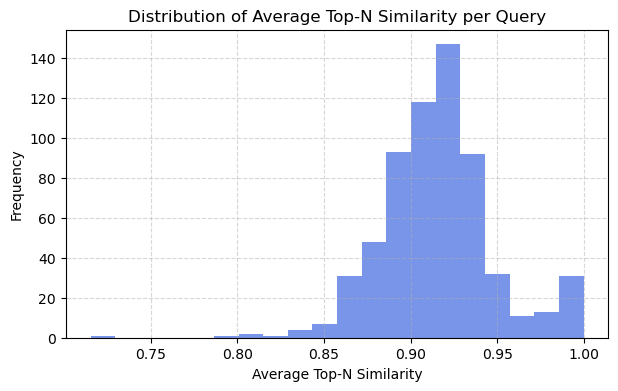

In [18]:



from tqdm import tqdm
import numpy as np
import random
import matplotlib.pyplot as plt

N = 3  # Atur N sesuai kebutuhan
relevance_dict = {}
similarity_scores = []  # Store average similarity for each query
topN_prompts = []  # Store top-N prompt texts for each query

for idx, row in tqdm(df.iterrows(), total=len(df)):
    query = row['prompt']
    results = retrieval_model.search(query, top_k=N+1)  # +1 untuk menghindari self-match
    result_indices = results.index.tolist()
    result_scores = results['score'].tolist()
    if idx in result_indices:
        remove_idx = result_indices.index(idx)
        result_indices.pop(remove_idx)
        result_scores.pop(remove_idx)
    relevance_dict[idx] = result_indices[:N]
    similarity_scores.append(np.mean(result_scores[:N]))
    topN_prompts.append(df.loc[result_indices[:N], 'prompt'].tolist())

# Tambahkan ke DataFrame untuk analisis manual
df['relevant_indices'] = df.index.map(relevance_dict)
df['avg_topN_similarity'] = similarity_scores
df['topN_prompts'] = topN_prompts

# Tampilkan contoh mapping relevansi dengan prompt dan skor
print('Contoh mapping relevansi (prompt, relevant prompts, avg similarity):')
for i in random.sample(range(len(df)), min(5, len(df))):
    prompt = df.loc[i, 'prompt']
    relevant_prompts = df.loc[i, 'topN_prompts']
    avg_sim = df.loc[i, 'avg_topN_similarity']
    print(f'Query: {prompt}\nRelevant: {relevant_prompts}\nAvg sim: {avg_sim:.3f}\n---')

# Visualisasi distribusi skor similarity
plt.figure(figsize=(7,4))
plt.hist(df['avg_topN_similarity'], bins=20, alpha=0.7, color='royalblue')
plt.xlabel('Average Top-N Similarity')
plt.ylabel('Frequency')
plt.title('Distribution of Average Top-N Similarity per Query')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [19]:
# --- Save DataFrame with relevance mapping to JSON (for fast reload, skip recompute) ---
import json

df_to_save = df.copy()
# Convert numpy types and lists to native Python types for JSON serialization
for col in ['relevant_indices', 'topN_prompts']:
    df_to_save[col] = df_to_save[col].apply(lambda x: list(map(int, x)) if col == 'relevant_indices' else x)

df_to_save['avg_topN_similarity'] = df_to_save['avg_topN_similarity'].astype(float)

with open('mbpp_all_with_embedding_and_relevance_v2.json', 'w', encoding='utf-8') as f:
    json.dump(df_to_save.to_dict(orient='records'), f, ensure_ascii=False, indent=2)

print('Saved DataFrame with relevance mapping to mbpp_all_with_embedding_and_relevance.json')

Saved DataFrame with relevance mapping to mbpp_all_with_embedding_and_relevance.json


In [20]:
# --- Enhanced Evaluation: Retrieval Metrics, Error Analysis, and Diversity ---
if 'relevance_dict' not in globals():
    raise RuntimeError('Jalankan cell Automatic Relevance Mapping (cell sebelumnya) terlebih dahulu!')

from sklearn.metrics import f1_score, precision_score, recall_score
from collections import Counter

best_f1 = 0
best_k = 1
results_dict = {}
error_cases = []
diversity_scores = []
for top_k in range(1, 11):
    y_true = []
    y_pred = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        query = row['prompt']
        relevant_indices = relevance_dict[idx]
        results = retrieval_model.search(query, top_k=top_k)
        result_indices = results.index.tolist()
        match = any(i in result_indices for i in relevant_indices)
        y_true.append(1)
        y_pred.append(1 if match else 0)
        # Error analysis: log false negatives
        if not match:
            error_cases.append({'query': query, 'relevant': [df.loc[i, 'prompt'] for i in relevant_indices], 'retrieved': [df.loc[i, 'prompt'] for i in result_indices]})
        # Diversity: unique prompt count in retrieval
        diversity_scores.append(len(set(result_indices)))
    f1 = f1_score(y_true, y_pred)
    results_dict[top_k] = f1
    if f1 > best_f1:
        best_f1 = f1
        best_k = top_k
print(f'Best top_k: {best_k} with F1-score: {best_f1:.4f}')
print('F1-scores by top_k:', results_dict)
print(f'Average retrieval diversity (unique prompts per query): {np.mean(diversity_scores):.2f}')
if error_cases:
    print(f'Example error case:')
    print('Query:', error_cases[0]['query'])
    print('Relevant:', error_cases[0]['relevant'])
    print('Retrieved:', error_cases[0]['retrieved'])

  0%|          | 0/632 [00:00<?, ?it/s]

100%|██████████| 632/632 [02:23<00:00,  4.41it/s]


Best top_k: 2 with F1-score: 1.0000
F1-scores by top_k: {1: 0.07317073170731707, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0, 10: 1.0}
Average retrieval diversity (unique prompts per query): 5.50
Example error case:
Query: Write a function to find the shared elements from the given two lists.
Relevant: ['Create a function that returns the elements found in both of the provided lists.', 'Write a function to find the common elements in given nested lists.', 'Develop a function that returns the elements shared by all nested lists.']
Retrieved: ['Write a function to find the shared elements from the given two lists.']


In [21]:
# 5. Save the model (with best_k from tuning)
# Pastikan variabel best_k dan tqdm sudah didefinisikan sebelum cell ini dijalankan
try:
    _ = best_k
except NameError:
    raise RuntimeError('Jalankan cell evaluasi hyperparameter (yang mendefinisikan best_k) terlebih dahulu!')
try:
    from tqdm import tqdm
except ImportError:
    raise ImportError('tqdm belum terinstall. Jalankan !pip install tqdm atau %pip install tqdm')

retrieval_model.best_k = best_k
import joblib
joblib.dump(retrieval_model, 'semantic_retrieval_mode_rev.pkl')


['semantic_retrieval_mode_rev.pkl']

In [22]:
# 6. Load and test the saved model with a user query
import joblib

# Path PKL harus sesuai lokasi file hasil dump
loaded_model = joblib.load('semantic_retrieval_mode_rev.pkl')
user_query = "find the maximum value in a list"
results = loaded_model.search(user_query, top_k=3)
print(results)


                                                prompt     score  \
139  Write a function to find the maximum value in ...  0.881030   
155  Write a function to find the list with maximum...  0.874503   
135  Write a function to find the list of maximum l...  0.871245   

                                                  code  
139  def max_val(listval):\n     max_val = max(i fo...  
155  def max_length_list(input_list):\n    max_leng...  
135  def max_length(list1):\n    max_length = max(l...  


In [24]:
loaded_model = joblib.load('semantic_retrieval_mode_rev.pkl')
user_query = "Temukan nilai maksimum dalam sebuah list"
results = loaded_model.search(user_query, top_k=3)
print(results)


                                                prompt     score  \
139  Write a function to find the maximum value in ...  0.885769   
135  Write a function to find the list of maximum l...  0.875365   
155  Write a function to find the list with maximum...  0.874187   

                                                  code  
139  def max_val(listval):\n     max_val = max(i fo...  
135  def max_length(list1):\n    max_length = max(l...  
155  def max_length_list(input_list):\n    max_leng...  


## 🔄 Cara Pakai & Testing PKL di Lingkungan Manapun

- **Production:**
  - Pastikan cell model1/model2/model3/translator sudah di-load.
  - Gunakan `get_ensemble_embedding` untuk retrieval_model.
- **Testing/Portabilitas:**
  - Ganti ke `dummy_embedding` agar PKL bisa di-load tanpa dependensi model.
  - Cocok untuk test API, CLI, atau deployment tanpa GPU/model besar.

**Contoh cell untuk load PKL dan test retrieval:**

In [27]:
# --- Load PKL & test retrieval (REAL mode, user input prompt, full table output) ---
import joblib
import pandas as pd
from IPython.display import display

# Pastikan cell model1, model2, model3, translator, dan get_ensemble_embedding sudah di-load!
loaded_model = joblib.load('semantic_retrieval_mode_rev.pkl')
loaded_model.encoder_func = get_ensemble_embedding  # Pakai fungsi embedding real

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 0)

user_query = input("Masukkan prompt: ")
print("User:",user_query)
print("SemSim Search:")
results = loaded_model.search(user_query, top_k=3)
display(results)


User: carikan saya nil;ai maksimum diantara 3 list
SemSim Search:


,prompt,score,code
155,Write a function to find the list with maximum length.,0.800187,"def max_length_list(input_list):\n max_length = max(len(x) for x in input_list ) \n max_list = max(input_list, key = lambda i: len(i)) \n return(max_length, max_list)"
135,Write a function to find the list of maximum length in a list of lists.,0.793205,"def max_length(list1):\n max_length = max(len(x) for x in list1 ) \n max_list = max((x) for x in list1)\n return(max_length, max_list)"
182,Write a python function to find element of a list having maximum length.,0.792123,def Find_Max(lst): \n maxList = max((x) for x in lst) \n return maxList
